In [ ]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.9 MB/s eta 0:00:00


<ipython-input-6-a219412d3429>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train = train_df1.drop(['temperature'], axis=1, inplace=True)
<ipython-input-6-a219412d3429>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test = test_df2.drop(['temperature'], axis=1, inplace=True)
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
<ipython-input-6-a219412d3429>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Pair: 18N_283.2E -> 17.36N_78.5E, MSE: 78.12782862156787, RMSE: 8.838994774382881, RMSPE: 0.6375795720297078, R^2: -1.7507216140328197
Pair: -33.9N_18.5E -> -33.5N_151E, MSE: 41.708836322224684, RMSE: 6.458237865101028, RMSPE: 0.30252777149985133, R^2: -0.20866993116730947
Pair: 41.9N_12.46E -> 40.75N_286.01E, MSE: 194.90212041353826, RMSE: 13.960734952485067, RMSPE: 52.406071340778446, R^2: -12.769385764774446
Pair: 43.28N_5.39E -> 43.64N_280.63E, MSE: 177.5047699065316, RMSE: 13.323091604673879, RMSPE: 61.20313933791832, R^2: -12.05538934165938
Pair: 51.5N_359.9E -> 51.03N_245.94E, MSE: 433.34306559024617, RMSE: 20.8168937545986, RMSPE: 1.8378967733274871, R^2: -18.993406710211133
Pair: 59.92N_10.75E -> 58.76N_265.83E, MSE: 1148.417558274376, RMSE: 33.88831005338531, RMSPE: 1.125833199091899, R^2: -39.73962234887276


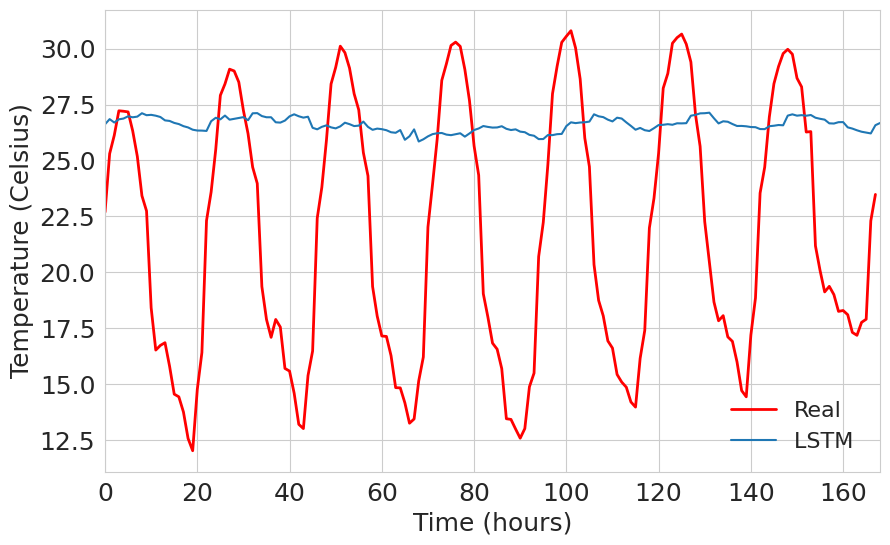

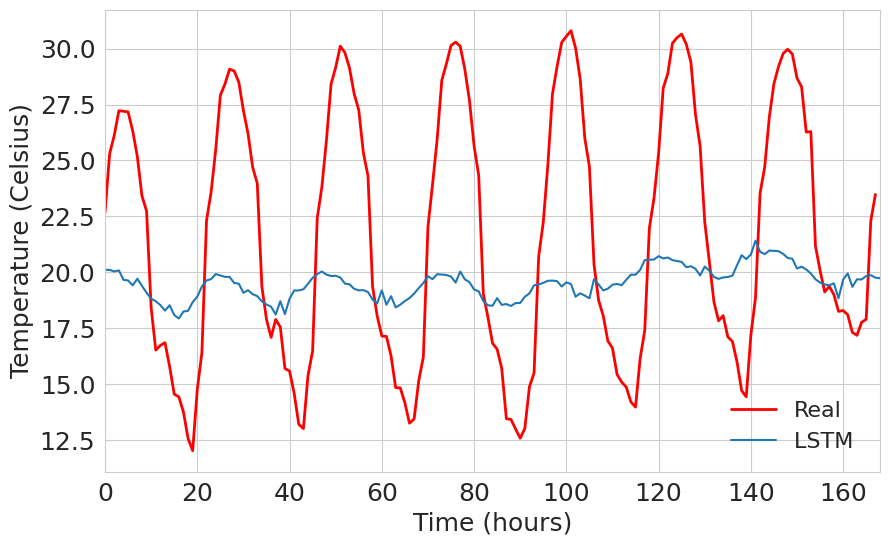

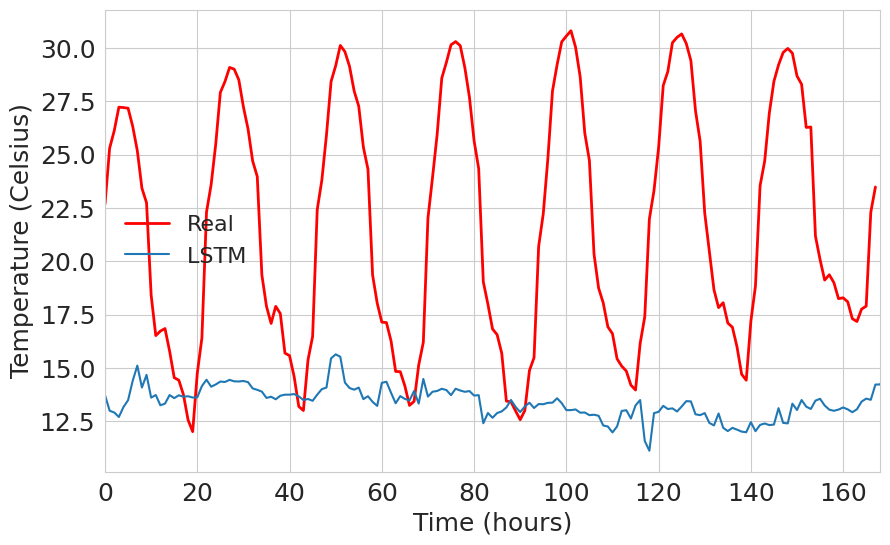

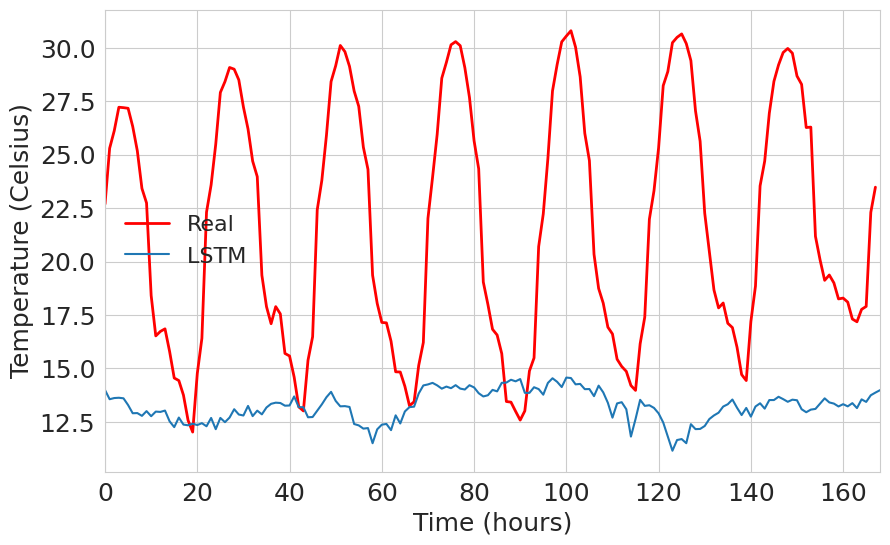

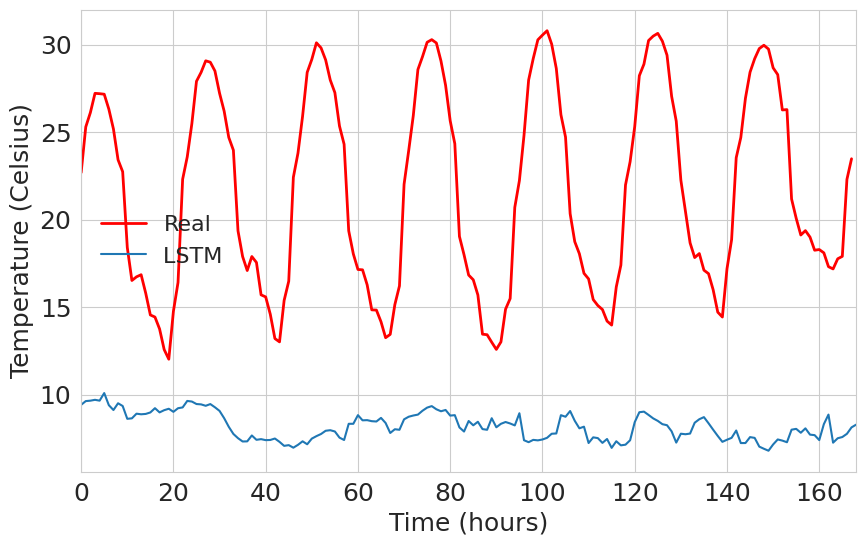

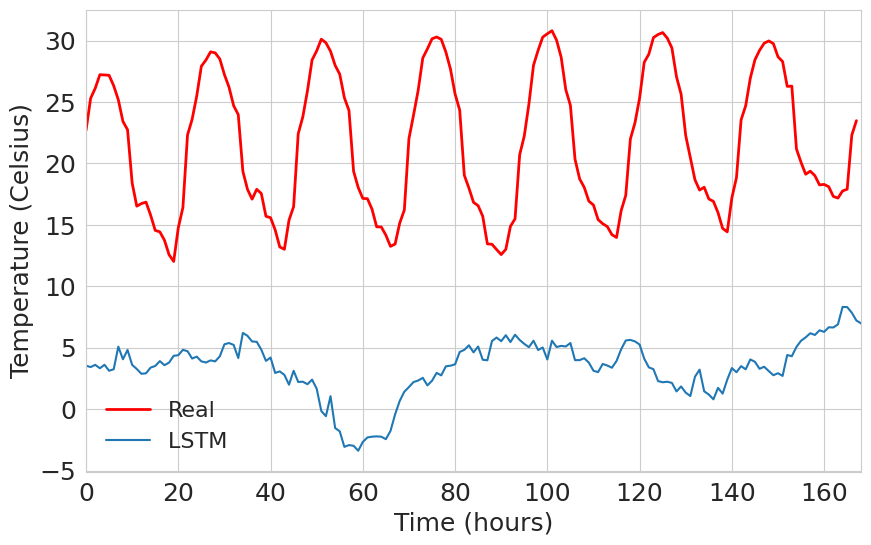

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# drive.mount('/content/drive')
folder_location = '/content/drive/MyDrive/Weather'
all_files = sorted(os.listdir(folder_location))

location_pairs = [('18N_283.2E','17.36N_78.5E'),
                  ('-33.9N_18.5E','-33.5N_151E'),
                  ('41.9N_12.46E','40.75N_286.01E'),
                  ('43.28N_5.39E','43.64N_280.63E'),
                  ('51.5N_359.9E','51.03N_245.94E'),
                  ('59.92N_10.75E','58.76N_265.83E')
]

results = []
for lat_long1, lat_long2 in location_pairs:
    file1 = f"{lat_long1}.csv"
    file2 = f"{lat_long2}.csv"
    if file1 in all_files and file2 in all_files:
        df1 = pd.read_csv(os.path.join(folder_location, file1))
        df1.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
        df1.temperature = df1.temperature - 273.15

        df1['date'] = pd.to_datetime(df1[['year', 'month', 'day', 'hour']])
        df1.set_index('date', inplace=True)

        hours_in_day = 24
        days_in_month = 30
        months_in_year = 12
        df1['hour_sin'] = np.sin(2 * np.pi * df1.index.hour / hours_in_day)
        df1['hour_cos'] = np.cos(2 * np.pi * df1.index.hour / hours_in_day)
        df1['day_sin'] = np.sin(2 * np.pi * df1.index.day / days_in_month)
        df1['day_cos'] = np.cos(2 * np.pi * df1.index.day / days_in_month)
        df1['month_sin'] = np.sin(2 * np.pi * df1.index.month / months_in_year)
        df1['month_cos'] = np.cos(2 * np.pi * df1.index.month / months_in_year)
        columns_to_drop = ['date','month','day','hour','year']
        df1 = df1.drop(columns=[col for col in columns_to_drop if col in df1.columns], axis=1)
        n_test = 24 * 7
        train_df1 = df1.iloc[-2000*24:-n_test]
        y_train = train_df1['temperature']
        X_train = train_df1.drop(['temperature'], axis=1, inplace=True)
        X_train = train_df1


        df2 = pd.read_csv(os.path.join(folder_location, file2))
        df2.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
        df2.temperature = df2.temperature - 273.15
        df2['date'] = pd.to_datetime(df2[['year', 'month', 'day', 'hour']])
        df2.set_index('date', inplace=True)

        # cyclic features
        hours_in_day = 24
        days_in_month = 30
        months_in_year = 12
        df2['hour_sin'] = np.sin(2 * np.pi * df2.index.hour / hours_in_day)
        df2['hour_cos'] = np.cos(2 * np.pi * df2.index.hour / hours_in_day)
        df2['day_sin'] = np.sin(2 * np.pi * df2.index.day / days_in_month)
        df2['day_cos'] = np.cos(2 * np.pi * df2.index.day / days_in_month)
        df2['month_sin'] = np.sin(2 * np.pi * df2.index.month / months_in_year)
        df2['month_cos'] = np.cos(2 * np.pi * df2.index.month / months_in_year)
        columns_to_drop = ['date','month','day','hour','year']
        df2 = df2.drop(columns=[col for col in columns_to_drop if col in df2.columns], axis=1)
        n_test = 24 * 7

        test_df2 = df2.iloc[-n_test-10:]
        y_test = test_df2['temperature']
        X_test = test_df2.drop(['temperature'], axis=1, inplace=True)
        X_test = test_df2


        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)





        # # LSTM
        # time_steps = 10
        # X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
        # X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
        # model = Sequential([
        # LSTM(16, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
        # Dropout(0.2),
        # LSTM(16),
        # Dense(1)
        # ])
        # model.compile(optimizer='adam', loss='mean_squared_error')
        # early_stop = EarlyStopping(monitor='loss', patience=5, mode='min')
        # model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


        # y_pred_lstm = model.predict(X_test_seq)
        # mse_lstm = np.mean((y_test_seq - y_pred_lstm)**2)

        # y_pred = model.predict(X_test_seq).flatten()
        xgb_model = XGBRegressor(n_estimators=100)
        xgb_model.fit(X_train_scaled, y_train, eval_metric="rmse")

        # predict and evaluate
        y_pred = xgb_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rmspe = np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))
        r2 = r2_score(y_test, y_pred)

        results.append((lat_long1, lat_long2, mse, rmse, rmspe, r2))

        # y_test = y_test[10:]
        # X_test = X_test[10:]
        # # Linear Regression
        # lr_model = LinearRegression()
        # lr_model.fit(X_train, y_train)
        # y_pred_lr = lr_model.predict(X_test)
        # mse_lr = np.mean((y_test - y_pred_lr)**2)

        # # XGBoost
        # xgb_model = XGBRegressor()
        # xgb_model.fit(X_train, y_train)
        # y_pred_xgb = xgb_model.predict(X_test)
        # mse_xgb = np.mean((y_test - y_pred_xgb)**2)

        # results.append((lat_long1, lat_long2, mse_lstm, mse_lr, mse_xgb))

        # # Plotting the results
        # # plt.figure(figsize=(10, 6))
        # # plt.plot(y_test_seq, label='Actual')
        # # plt.plot(y_pred_lstm, label='LSTM')
        # # plt.plot(y_pred_lr, label='Linear Regression')
        # # plt.plot(y_pred_xgb, label='XGBoost')
        # # plt.title(f'Temperature Prediction for {lat_long2} based on {lat_long1}')
        # # plt.xlabel('Time Steps')
        # # plt.ylabel('Temperature')
        # # plt.legend()
        # # plt.show()

        import seaborn as sns
        sns.set_style("whitegrid")
        fig = plt.figure(figsize=(10, 6))
        # plt.plot(range(len(y_test)), lr_preds)
        # plt.plot(range(len(y_test)), lr2_preds)
        # plt.plot(range(len(y_test)), y_test, 'r', linewidth=2)
        # legend_labels = ['Linear regression A', 'Linear regression B', 'Real']

        plt.plot(y_test_seq,  'r', linewidth=2, label='Real')
        plt.plot(y_pred, label='LSTM ')
        # plt.plot(y_pred_lr, label='Linear Regression ')
        # plt.plot(y_pred_xgb, label='XGBoost')

        # Plot the legend with different number of columns
        plt.legend(frameon=False, fontsize=16)
        plt.ylabel("Temperature (Celsius)", fontsize=18)
        plt.xlabel("Time (hours)", fontsize=18)
        # plt.xticks([0, 24, 48, 72, 96, 120, 144, 168])
        # plt.yticks([-6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16])
        # plt.ylim([0, 40])
        plt.xlim([0,168])
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)

# Output results
for result in results:
    print(f"Pair: {result[0]} -> {result[1]}, MSE: {result[2]}, RMSE: {result[3]}, RMSPE: {result[4]}, R^2: {result[5]}")


<ipython-input-7-d05ae37b6936>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train = train_df1.drop(['temperature'], axis=1, inplace=True)
<ipython-input-7-d05ae37b6936>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test = test_df2.drop(['temperature'], axis=1, inplace=True)
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
<ipython-input-7-d05ae37b6936>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Pair: 17.36N_78.5E -> 18N_283.2E, MSE: 49.42423208567951, RMSE: 7.030236986452129, RMSPE: 0.26284673963593097, R^2: -207.58866140612062
Pair: -33.5N_151E -> -33.9N_18.5E, MSE: 29.09308054830968, RMSE: 5.3938001954382475, RMSPE: 0.29749898858342216, R^2: -18.662769376626574
Pair: 40.75N_286.01E -> 41.9N_12.46E, MSE: 168.83426832147566, RMSE: 12.993624141149985, RMSPE: 1.0091723850451249, R^2: -182.62470828536243
Pair: 43.64N_280.63E -> 43.28N_5.39E, MSE: 174.74247074124392, RMSE: 13.219019280613972, RMSPE: 0.9944976473237435, R^2: -140.68625674296703
Pair: 51.03N_245.94E -> 51.5N_359.9E, MSE: 393.76116105402394, RMSE: 19.843416063118365, RMSPE: 1.8859129118819458, R^2: -1274.8314004352235
Pair: 58.76N_265.83E -> 59.92N_10.75E, MSE: 846.763179159249, RMSE: 29.099195507079727, RMSPE: 277.234749125052, R^2: -151.55290994321192


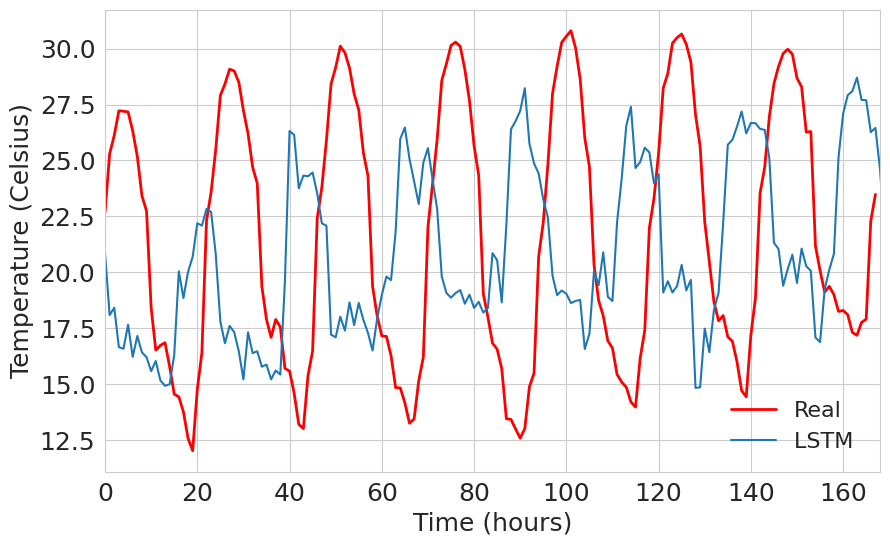

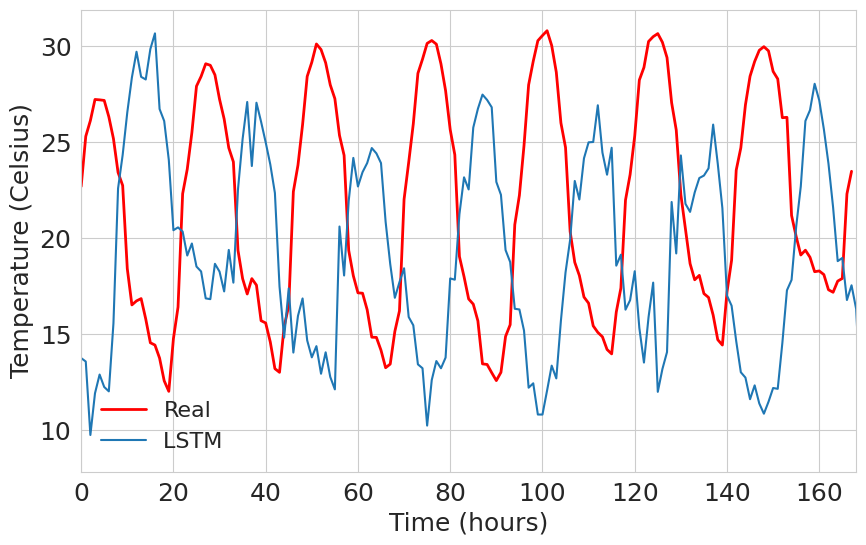

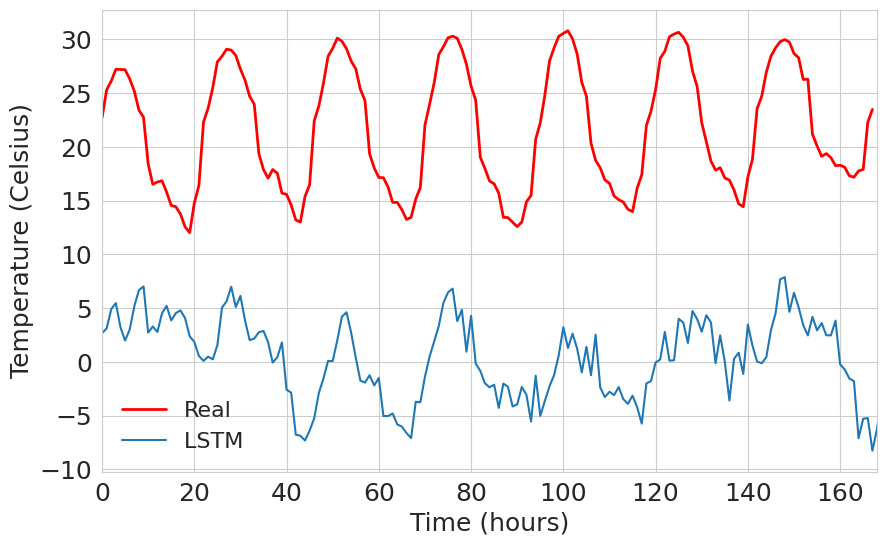

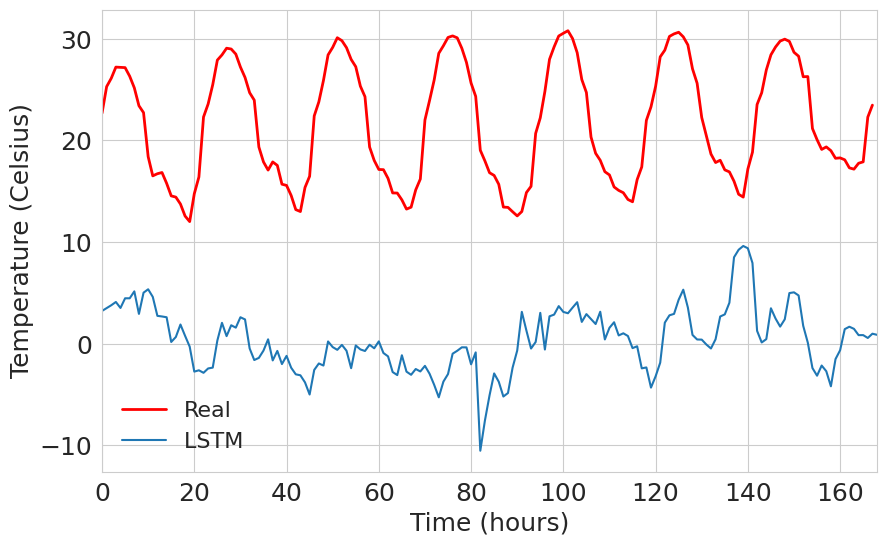

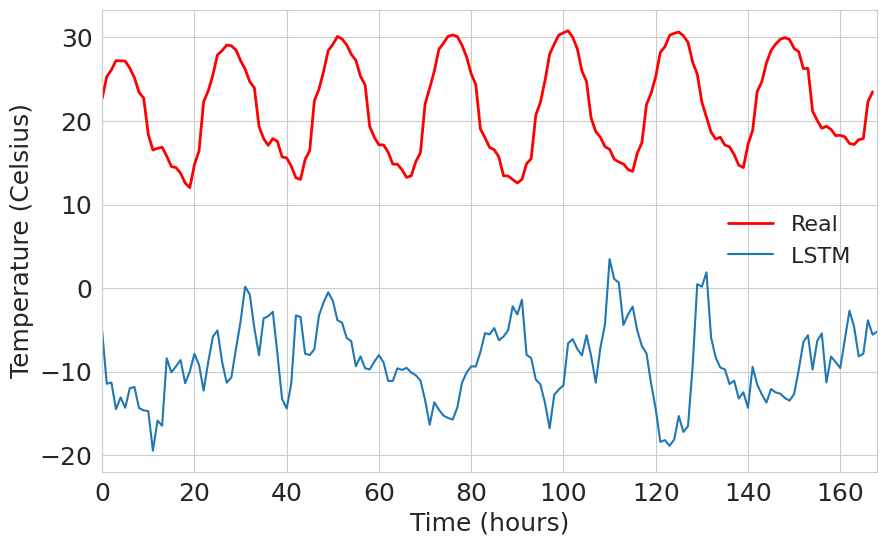

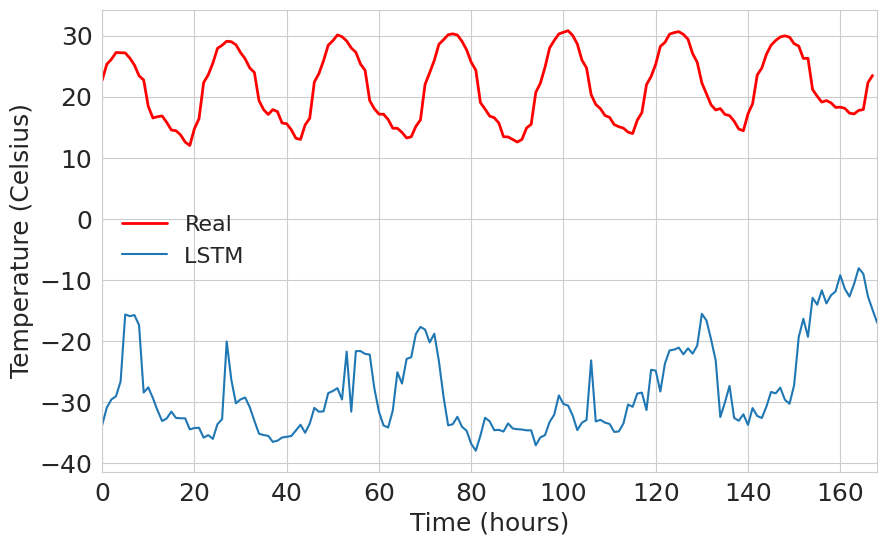

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


# drive.mount('/content/drive')
folder_location = '/content/drive/MyDrive/Weather'
all_files = sorted(os.listdir(folder_location))

location_pairs = [('17.36N_78.5E','18N_283.2E'),
                  ('-33.5N_151E','-33.9N_18.5E'),
                  ('40.75N_286.01E','41.9N_12.46E'),
                  ('43.64N_280.63E', '43.28N_5.39E'),
                  ('51.03N_245.94E', '51.5N_359.9E'),
                  ('58.76N_265.83E', '59.92N_10.75E')
]

results = []
for lat_long1, lat_long2 in location_pairs:
    file1 = f"{lat_long1}.csv"
    file2 = f"{lat_long2}.csv"
    if file1 in all_files and file2 in all_files:
        df1 = pd.read_csv(os.path.join(folder_location, file1))
        df1.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
        df1.temperature = df1.temperature - 273.15

        df1['date'] = pd.to_datetime(df1[['year', 'month', 'day', 'hour']])
        df1.set_index('date', inplace=True)

        hours_in_day = 24
        days_in_month = 30
        months_in_year = 12
        df1['hour_sin'] = np.sin(2 * np.pi * df1.index.hour / hours_in_day)
        df1['hour_cos'] = np.cos(2 * np.pi * df1.index.hour / hours_in_day)
        df1['day_sin'] = np.sin(2 * np.pi * df1.index.day / days_in_month)
        df1['day_cos'] = np.cos(2 * np.pi * df1.index.day / days_in_month)
        df1['month_sin'] = np.sin(2 * np.pi * df1.index.month / months_in_year)
        df1['month_cos'] = np.cos(2 * np.pi * df1.index.month / months_in_year)
        columns_to_drop = ['date','month','day','hour','year']
        df1 = df1.drop(columns=[col for col in columns_to_drop if col in df1.columns], axis=1)
        n_test = 24 * 7
        train_df1 = df1.iloc[-2000*24:-n_test]
        y_train = train_df1['temperature']
        X_train = train_df1.drop(['temperature'], axis=1, inplace=True)
        X_train = train_df1


        df2 = pd.read_csv(os.path.join(folder_location, file2))
        df2.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
        df2.temperature = df2.temperature - 273.15
        df2['date'] = pd.to_datetime(df2[['year', 'month', 'day', 'hour']])
        df2.set_index('date', inplace=True)

        hours_in_day = 24
        days_in_month = 30
        months_in_year = 12
        df2['hour_sin'] = np.sin(2 * np.pi * df2.index.hour / hours_in_day)
        df2['hour_cos'] = np.cos(2 * np.pi * df2.index.hour / hours_in_day)
        df2['day_sin'] = np.sin(2 * np.pi * df2.index.day / days_in_month)
        df2['day_cos'] = np.cos(2 * np.pi * df2.index.day / days_in_month)
        df2['month_sin'] = np.sin(2 * np.pi * df2.index.month / months_in_year)
        df2['month_cos'] = np.cos(2 * np.pi * df2.index.month / months_in_year)
        columns_to_drop = ['date','month','day','hour','year']
        df2 = df2.drop(columns=[col for col in columns_to_drop if col in df2.columns], axis=1)
        n_test = 24 * 7

        test_df2 = df2.iloc[-n_test-10:]
        y_test = test_df2['temperature']
        X_test = test_df2.drop(['temperature'], axis=1, inplace=True)
        X_test = test_df2

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)





        # # LSTM
        # time_steps = 10
        # X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
        # X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
        # model = Sequential([
        # LSTM(16, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
        # Dropout(0.2),
        # LSTM(16),
        # Dense(1)
        # ])
        # model.compile(optimizer='adam', loss='mean_squared_error')
        # early_stop = EarlyStopping(monitor='loss', patience=5, mode='min')
        # model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


        # y_pred_lstm = model.predict(X_test_seq)
        # mse_lstm = np.mean((y_test_seq - y_pred_lstm)**2)

        # y_pred = model.predict(X_test_seq).flatten()
        xgb_model = XGBRegressor(n_estimators=100)
        xgb_model.fit(X_train_scaled, y_train, eval_metric="rmse")

        # Predict and evaluate
        y_pred = xgb_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rmspe = np.sqrt(np.mean(np.square((y_test - y_pred) / y_test)))
        r2 = r2_score(y_test, y_pred)

        results.append((lat_long1, lat_long2, mse, rmse, rmspe, r2))

        # y_test = y_test[10:]
        # X_test = X_test[10:]
        # # Linear Regression
        # lr_model = LinearRegression()
        # lr_model.fit(X_train, y_train)
        # y_pred_lr = lr_model.predict(X_test)
        # mse_lr = np.mean((y_test - y_pred_lr)**2)

        # # XGBoost
        # xgb_model = XGBRegressor()
        # xgb_model.fit(X_train, y_train)
        # y_pred_xgb = xgb_model.predict(X_test)
        # mse_xgb = np.mean((y_test - y_pred_xgb)**2)

        # results.append((lat_long1, lat_long2, mse_lstm, mse_lr, mse_xgb))

        # # Plotting the results
        # # plt.figure(figsize=(10, 6))
        # # plt.plot(y_test_seq, label='Actual')
        # # plt.plot(y_pred_lstm, label='LSTM')
        # # plt.plot(y_pred_lr, label='Linear Regression')
        # # plt.plot(y_pred_xgb, label='XGBoost')
        # # plt.title(f'Temperature Prediction for {lat_long2} based on {lat_long1}')
        # # plt.xlabel('Time Steps')
        # # plt.ylabel('Temperature')
        # # plt.legend()
        # # plt.show()

        import seaborn as sns
        sns.set_style("whitegrid")
        fig = plt.figure(figsize=(10, 6))
        # plt.plot(range(len(y_test)), lr_preds)
        # plt.plot(range(len(y_test)), lr2_preds)
        # plt.plot(range(len(y_test)), y_test, 'r', linewidth=2)
        # legend_labels = ['Linear regression A', 'Linear regression B', 'Real']

        plt.plot(y_test_seq,  'r', linewidth=2, label='Real')
        plt.plot(y_pred, label='LSTM ')
        # plt.plot(y_pred_lr, label='Linear Regression ')
        # plt.plot(y_pred_xgb, label='XGBoost')

        # Plot the legend with different number of columns
        plt.legend(frameon=False, fontsize=16)
        plt.ylabel("Temperature (Celsius)", fontsize=18)
        plt.xlabel("Time (hours)", fontsize=18)
        # plt.xticks([0, 24, 48, 72, 96, 120, 144, 168])
        # plt.yticks([-6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16])
        # plt.ylim([0, 40])
        plt.xlim([0,168])
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)

for result in results:
    print(f"Pair: {result[0]} -> {result[1]}, MSE: {result[2]}, RMSE: {result[3]}, RMSPE: {result[4]}, R^2: {result[5]}")
